# Plotting SMAP data from HDF5 Files

This notebook demonstrates how to read and plot data acquired by NASA's Soil Moisture Active Passive (SMAP) satellite, in particular the [*SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture, Version 6 (SPL3SMP)*](https://doi.org/10.5067/EVYDQ32FNWTH) data product (release [R16010](https://nsidc.org/data/smap/data_versions#L3)).

**Data citation:**

O'Neill, P. E., S. Chan, E. G. Njoku, T. Jackson, R. Bindlish, and J. Chaubell. 2019. SMAP L3 Radiometer Global Daily 36 km EASE-Grid Soil Moisture, Version 6. Boulder, Colorado USA. NASA National Snow and Ice Data Center Distributed Active Archive Center. doi: https://doi.org/10.5067/EVYDQ32FNWTH. Date accessed: June 2020.

This first cell imports all of the Python libraries and modules needed to read HDF5 files and plot data:

In [8]:
# import libraries/modules needed:

# the os module is used to create paths to data
import os

# the Path module is used to get paths to files of interest
from pathlib import Path as path

# matplotlib is used to plot data
# (anim is a submodule that can be used to create animations)
from matplotlib import pyplot as plt
# from matplotlib import animation as anim

# Basemap is a module used for plotting maps
from mpl_toolkits.basemap import Basemap

# rasterio is a module used to read/write geospatial raster data
import rasterio as rio

# rasterio reads raster data into numpy arrays so we need numpy too
import numpy as np

Here, filepaths are created and stored in string [constants](https://www.programiz.com/python-programming/variables-constants-literals#value-constant). The `os.path.join()` function builds paths that work across operating systems.

In [9]:
# create variables holding paths to input data
DATA_DIR = os.path.join('..', 'data')
INPUT_DATA_DIR = os.path.join(DATA_DIR, 'input')
SMAP_DATA_DIR = os.path.join(INPUT_DATA_DIR, 'SMAP', 'SPL3SMP.005')

# file suffix pattern for the SMAP files of interest
SMAP_FILE_SUFFIX = '*_R16010_001.h5'

# get paths to all HDF5 files ending with SMAP_FILE_SUFFIX
# found in all directories within SMAP_DATA_DIR
DATA_PATHS = sorted([str(filepath) for filepath in path(SMAP_DATA_DIR).rglob(SMAP_FILE_SUFFIX)])

# get the first in path DATA_PATHS to use for testing
TEST_DATA_PATH = DATA_PATHS[0]

# the HDF5 files contain many datasets, but
# the soil_moisture dataset is what we're interested in
SM_DATASET_NAME = 'soil_moisture'

# create variables to hold path to files containing EASE grid lat/lons (used for plotting)
# data source: https://github.com/TUW-GEO/ease_grid/tree/master/tests/test_data
EASE_GRID_DIR = os.path.join(DATA_DIR, 'ease_grid')
EASE_LATS_PATH = os.path.join(EASE_GRID_DIR, 'EASE2_M36KM.lats.964x406x1.double')
EASE_LONS_PATH = os.path.join(EASE_GRID_DIR, 'EASE2_M36KM.lons.964x406x1.double')

# store the EPSG projection code for the EASE Grid
# that this data uses (not used in this notebook)
EASE_EPSG = 'epsg:3410'

# create a path to an output directory in case
# we want to save files at some point
OUTPUT_DIR = os.path.join(DATA_DIR, 'output')

# check if OUTPUT_DIR exists and, if not, create it
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

SMAP data is projected in the [EASE-Grid 2.0](https://nsidc.org/data/ease/ease_grid2.html) format ([data source](https://github.com/TUW-GEO/ease_grid/tree/master/tests/test_data)). While each file includes `latitude` and `longitude` datasets that can be used for plotting data from individual files, plotting transformed or combined datasets (i.e., time-averaged) with these datasets will result in stripes where data is not plotted. It is easier to just use the full EASE-Grid when passing lat/lon or x/y information to the plotting functions.

The `numpy.fromfile()` function is used to read binary files. In this case it returns a 1-dimensional array of shape `(391384,)`. The EASE-Grid 2.0 has the shape `(406, 964)`. The `reshape()` function is used to transform the 1-d array into a 2-d array of the desired shape--if possible.

In [10]:
# read EASE2 lat/lons and then reshape from a 1D to 2D array matching the EASE Grid shape (EASE_SHAPE)
EASE_SHAPE = (406, 964)
EASE_LATS = np.fromfile(EASE_LATS_PATH, dtype=np.float64).reshape(EASE_SHAPE)
EASE_LONS = np.fromfile(EASE_LONS_PATH, dtype=np.float64).reshape(EASE_SHAPE)

Set the output figure size. Not really necessary in this demo, but if we want to change it at some point it's easier to change up here than down in the plot function.

In [11]:
# create variable to store output figure size
FIG_SIZE = (30, 10)

What datasets does a particular file contain? Call `print_dataset_names()` to find out!

To efficiently access a file, use the `with` syntax as below. The file closes automatically at the end of the code block. The `rasterio` module is used to open the file. The variable `src` is a `rasterio` object called `DataReader` that we can use to read attributes from the file. The `subdatasets` attribute is a list of paths to each subdataset the file contains. This function opens the HDF5 file at `src_path` and loops over the subdataset paths to print the names of each subdataset. The subdataset paths are *long*. For example:

```sh
HDF5:../data/input/SMAP/SPL3SMP.005/2017.03.01/SMAP_L3_SM_P_20170301_R16010_001.h5://Soil_Moisture_Retrieval_Data_AM/soil_moisture
```

The interesting part comes after the double forward slash:

```sh
Soil_Moisture_Retrieval_Data_AM/soil_moisture
```

The `split()` function built into `str` objects is used to print only the text after the `//` as above.

In [12]:
def print_dataset_names(src_path: str):
    '''
    Print name of datasets in file at src_path.
    '''
    
    # open file at src_path with rasterio
    with rio.open(src_path) as src:
        # get the list of subdataset paths
        subdatasets = src.subdatasets
        # loop over the subdataset paths
        for data_path in subdatasets:
            # extract the dataset name from the data path
            dataset_name = data_path.split('//')[-1]
            # print the name of the subdataset
            print(dataset_name)

In [13]:
print_dataset_names(TEST_DATA_PATH)

Soil_Moisture_Retrieval_Data_AM/EASE_column_index
Soil_Moisture_Retrieval_Data_AM/latitude_centroid
Soil_Moisture_Retrieval_Data_AM/longitude
Soil_Moisture_Retrieval_Data_AM/longitude_centroid
Soil_Moisture_Retrieval_Data_AM/radar_water_body_fraction
Soil_Moisture_Retrieval_Data_AM/retrieval_qual_flag
Soil_Moisture_Retrieval_Data_AM/roughness_coefficient
Soil_Moisture_Retrieval_Data_AM/soil_moisture
Soil_Moisture_Retrieval_Data_AM/soil_moisture_error
Soil_Moisture_Retrieval_Data_AM/static_water_body_fraction
Soil_Moisture_Retrieval_Data_AM/surface_flag
Soil_Moisture_Retrieval_Data_AM/EASE_row_index
Soil_Moisture_Retrieval_Data_AM/surface_temperature
Soil_Moisture_Retrieval_Data_AM/surface_water_fraction_mb_h
Soil_Moisture_Retrieval_Data_AM/surface_water_fraction_mb_v
Soil_Moisture_Retrieval_Data_AM/tb_3_corrected
Soil_Moisture_Retrieval_Data_AM/tb_4_corrected
Soil_Moisture_Retrieval_Data_AM/tb_h_corrected
Soil_Moisture_Retrieval_Data_AM/tb_h_uncorrected
Soil_Moisture_Retrieval_Data_AM/

Now that we know what datasets are available, we can start reading in the data we're interested in. Again, `rasterio` is used to open a connection to the file before looping over the subdatasets. Conditional `if-then` statements are then used to read the dataset of interest (`dataset_name`).

In SMAP data, the `nodata` value is -9999.0. The function below can mask the `nodata` values by replacing them with `np.nan`. Masking the `nodata` values is the default behavior of the function. To return unmasked data containing the SMAP `nodata` values, pass `mask_nodata=False` as an argument. Replacing `-9999.0` with `np.nan` allows us to use `numpy` functions that ignore `np.nan` values (e.g., `np.nanmean`, `np.nanmin`, `np.nanmax`).

In [14]:
def read_dataset(src_path: str, target_dataset: str, mask_nodata: bool = True):
    '''
    Read dataset_name in HDF5 file at src_path.
    '''
    # open the file with rasterio
    with rio.open(src_path) as src:
        
        # get list of subdatasets
        subdatasets = src.subdatasets
        
        # loop over subdatasets
        for data_path in subdatasets:
            # split the name of the dataset out of the path
            dataset_name = data_path.split('/')[-1]
            
            # compare the dataset_name with the target_dataset
            if dataset_name == target_dataset:
                
                # open the target subdataset
                with rio.open(data_path) as subdataset:
                    
                    # read the data into a numpy array
                    data = subdataset.read(1)
                    
                    # get the metadata associated with the subdataset
                    # (e.g., CRS, nodata value, filetype, shape)
                    meta = subdataset.meta
                    
                    # get additional metadata associated with the subdataset
                    # (e.g., units, valid min/max values, long name of dataset)
                    desc = subdataset.tags(bidx=1) # additional metadata (e.g., units)
                    
                    # the metadata in the file lacks projection information
                    # it's added here, but not really used in this script
                    meta['crs'] = EASE_EPSG
                    
                    # check whether to mask the data
                    if mask_nodata:
                        
                        # replace any cells containing the nodata value (-9999.0)
                        # with np.nan
                        data[data == meta['nodata']] = np.nan

    # return the data, metadata, and add'l metadata
    return data, meta, desc

This function specifically reads in the `latitude` and `longitude` datasets in SMAP files. This isn't really used in this script because it relies on the EASE-Grid 2.0 dataset instead, but it can be nice to have if we need to reproject the data at some point? Honestly, it could probably be refined to use `read_dataset()` above...!

In [15]:
def read_coords(src_path: str):
    '''
    Read and return lat/lon from HDF5 file at src_path.
    '''

    with rio.open(src_path) as src:
        subdatasets = src.subdatasets
        lat = ''
        lon = ''
        for data_path in subdatasets:
            name = data_path.split('/')[-1]
            if name == 'longitude':
                with rio.open(data_path) as subdataset:
                    lon = subdataset.read(1)
            elif name == 'latitude':
                with rio.open(data_path) as subdataset:
                    lat = subdataset.read(1)
    return lat, lon

The next function reads multiple datasets, passed in a list, and creates a 3-dimensional `numpy` array. In the case of this data, the returned array is of shape `(406, 964, n)` where `n` is the number of datasets read in. Think of them like the multiple bands that make up a Landsat image.

In [16]:
def calc_mean_dataset(data_paths: list, dataset_name: str):
    '''
    Read in data and calculate mean.
    '''

    # create some empty variables that we'll add to
    datasets = []
    meta = None
    desc = None
    
    # loop over the paths to each file
    for data_path in data_paths:
        
        # read each dataset
        dataset, meta, desc = read_dataset(data_path, dataset_name)
        
        # append the 2d array to the 3d array
        datasets.append(dataset)

    # return the data, metadata, and add'l metadata
    return np.dstack(datasets), meta, desc

Now that we can read the data and perform a simple calculation across files, we're ready to plot.

The function below uses the `matplotlib.pyplot` (used with the nickname `plt` here) and [`Basemap`](https://matplotlib.org/basemap/) modules. `Basemap` provides map plotting functionality and works well-ish with `matplotlib`.

In [17]:
def plot_data(data: np.ndarray, \
                    dataset_name: str, dataset_desc: dict, \
                    lats: np.ndarray = EASE_LATS, lons: np.ndarray = EASE_LONS, \
                    projection: str = 'cyl', cmap: str = 'viridis_r'):

    '''
    Plot data.
    '''
    
    # extract some useful metadata (e.g., units, valid min/max)
    long_name, units, vmin, vmax = (None, None, None, None)

    for descriptor in dataset_desc.keys():
        if 'long_name' in descriptor:
            long_name = dataset_desc[descriptor]
        elif 'units' in descriptor:
            units = dataset_desc[descriptor]
        elif 'valid_min' in descriptor:
            vmin = dataset_desc[descriptor]
        elif 'valid_max' in descriptor:
            vmax = dataset_desc[descriptor]
    
    # define the plot size and create an axis object (ax) to plot on
    fig, ax = plt.subplots(figsize=FIG_SIZE)

    # select the projection to plot with (see Basemap docs to learn more)
    # create an object we can add plot elements to (map_plot)
    if projection == 'robin':
        map_plot = Basemap(projection='robin', resolution='c', lat_0=0, lon_0=0, ax=ax)
        lons, lats = map_plot(lons, lats)
    else:
        map_plot = Basemap(projection='cyl', resolution='l', ax=ax)

    # plots need titles! this uses the long-name found in the add'l metadata
    # pad=40 moves the tile up so it doesn't cover lat/lon labels added later
    ax.set_title(long_name.split('.')[0].upper(), pad=40)

    # plot the actual data!
    cs = map_plot.pcolor(lons, lats, data, latlon=True, cmap=cmap, vmin=vmin, vmax=vmax)
    
    # add a color bar with units labeled
    cbar = map_plot.colorbar(mappable=cs, location='bottom', pad='5%')
    cbar.set_label(f'{dataset_name.upper()} ({units})')

    # add global coastlines to the plot
    map_plot.drawcoastlines()
    
    # add country borders to the plot
    map_plot.drawcountries()

    # add lat/lon lines and labels 
    paralells = np.arange(-90, 91, 30)
    meridians = np.arange(-180, 180, 30)
    labels = [True for i in paralells]

    map_plot.drawparallels(paralells, color='gray', labels=labels)
    map_plot.drawmeridians(meridians, color='gray', labels=labels)
    
    # water should look like water!
    map_plot.drawlsmask(ocean_color='lightblue')

    # the big reveal...
    plt.show()

Let's test it out. The functions below demonstrate how to (1) plot data from a single file/dataset and (2) plot the mean of several datasets.

In [18]:
def test_plot_single():
    '''
    Plot data from a single dataset (TEST_DATA_PATH)
    '''
    sm_data, sm_meta, sm_desc = read_dataset(TEST_DATA_PATH, SM_DATASET_NAME)
    plot_data(sm_data, SM_DATASET_NAME, sm_desc)

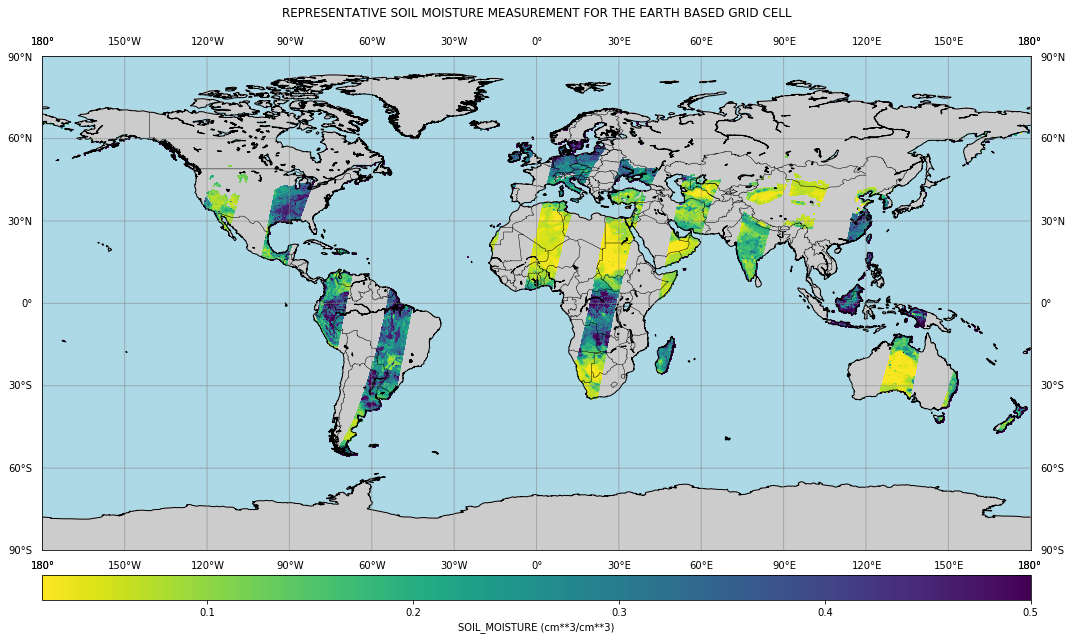

In [19]:
test_plot_single()

In [20]:
def test_plot_mean():
    '''
    Calculate and plot mean of soil_moisture datasets contained in 
    files that match the SMAP_FILE_SUFFIX pattern.
    '''

    test_dataset, test_meta, test_desc = calc_mean_dataset(DATA_PATHS, SM_DATASET_NAME)
    # update long_name variable to add "Mean" to title of plot
    test_desc['Soil_Moisture_Retrieval_Data_AM_soil_moisture_long_name'] = ' Mean Representative soil moisture measurement for the Earth based grid cell.'
    mean_sm = np.nanmean(test_dataset, axis=2)
    plot_data(mean_sm, SM_DATASET_NAME, test_desc)

<ipython-input-20-829e2292f713>:10: RuntimeWarning: Mean of empty slice
  mean_sm = np.nanmean(test_dataset, axis=2)


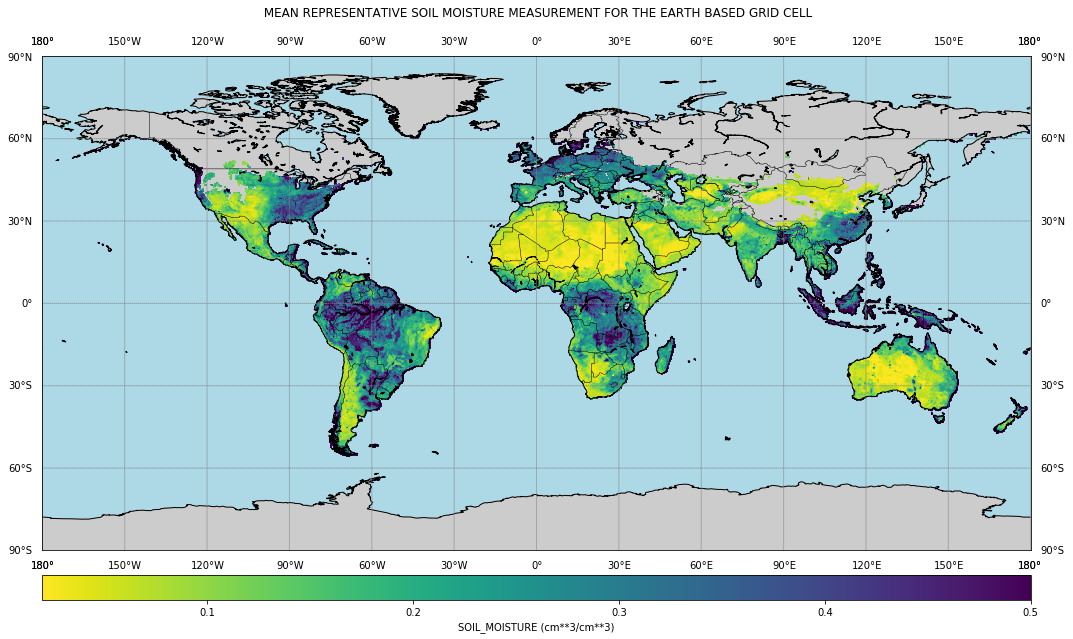

In [21]:
test_plot_mean()

# note: the RuntimeWarning below can be safely ignored. There's an empty dataset in there somewhere...

The function below will create and save a plot in the `OUTPUT_DIR`. In the current form it only plots data from individual files, but could easily be updated to create and save the above time-averaged plot.

In [22]:
def save_plots(data_paths: list, dataset_name: str):
    '''
    Save plots of data.
    '''

    for data_path in data_paths:
        plot_date = data_path.split('/')[-2]
        data, meta, desc = read_dataset(data_path, dataset_name)
        plot_data(data, dataset_name, desc)
        plt.title(plot_date)

        out_fp = os.path.join(OUTPUT_DIR, f'{plot_date}.png')
        plt.savefig(out_fp)